# Telecom Churn Prediction Project

## Business Objective
The goal of this project is to predict customer churn for high-value customers in the telecom industry. The dataset contains customer-level information for four consecutive months (June, July, August, and September). We will use data from the first three months to predict churn in the fourth month. The key steps include:
1. Filtering high-value customers.
2. Tagging churners based on their activity in the fourth month.
3. Building a predictive model to identify customers at risk of churn.
4. Identifying important predictors of churn to inform business strategies.

---

## Step 1: Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

## Step 2: Load the data

In [5]:
# Load the dataset
data = pd.read_csv('telecom_churn_data.csv')

# Display the first 5 rows
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [7]:
data.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

## Step 3: Data Understanding and Preparation

### 3.1 Data Quality Checks

In [10]:
# Check for missing values
missing_columns=data.isnull().sum()
print("Missing values in each column:")
print(missing_columns)

# Check for duplicate rows
print("\nNumber of duplicate rows:", data.duplicated().sum())

Missing values in each column:
mobile_number        0
circle_id            0
loc_og_t2o_mou    1018
std_og_t2o_mou    1018
loc_ic_t2o_mou    1018
                  ... 
aon                  0
aug_vbc_3g           0
jul_vbc_3g           0
jun_vbc_3g           0
sep_vbc_3g           0
Length: 226, dtype: int64

Number of duplicate rows: 0


### 3.2 Handle Missing Values

In [12]:
# Step 1: Fill missing values with 0 for usage,recharge and data recharge columns & with median for revenue & ARPU columns
# Usage Columns
usage_columns = ['total_ic_mou_6', 'total_og_mou_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 
                 'total_ic_mou_7', 'total_og_mou_7', 'vol_2g_mb_7', 'vol_3g_mb_7', 
                 'total_ic_mou_8', 'total_og_mou_8', 'vol_2g_mb_8', 'vol_3g_mb_8']
data[usage_columns] = data[usage_columns].fillna(0)

In [13]:
# Recharge Columns
recharge_columns = ['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 
                    'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8']
data[recharge_columns] = data[recharge_columns].fillna(0)

In [14]:
# Recharge and Data Usage Columns
recharge_data_columns = ['total_rech_data_6', 'max_rech_data_6', 'av_rech_amt_data_6', 
                         'total_rech_data_7', 'max_rech_data_7', 'av_rech_amt_data_7', 
                         'total_rech_data_8', 'max_rech_data_8', 'av_rech_amt_data_8', 
                         'total_rech_data_9', 'max_rech_data_9', 'av_rech_amt_data_9']
data[recharge_data_columns] = data[recharge_data_columns].fillna(0)

In [15]:
# Fill missing values with median for revenue & ARPU columns
revenue_columns = ['arpu_3g_6', 'arpu_2g_6', 'arpu_3g_7', 'arpu_2g_7', 
                   'arpu_3g_8', 'arpu_2g_8']
data[revenue_columns] = data[revenue_columns].fillna(data[revenue_columns].median())

In [16]:
# ARPU Columns
arpu_columns = ['arpu_2g_6', 'arpu_3g_6', 'arpu_2g_7', 'arpu_3g_7', 
                'arpu_2g_8', 'arpu_3g_8', 'arpu_2g_9', 'arpu_3g_9']
data[arpu_columns] = data[arpu_columns].fillna(data[arpu_columns].median())

In [17]:
# Step 2 : Convert Date Columns to numeric features & drop original columns
date_columns = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
                'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
                'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 
                'date_of_last_rech_data_8', 'date_of_last_rech_data_9']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')
    data[f'days_since_{col}'] = (pd.to_datetime('today') - data[col]).dt.days.fillna(9999)  # 9999 for no recharge

# Drop the original date columns
data.drop(columns=date_columns, inplace=True)

In [18]:
# Step 3: Handle columns with >40% missing values
missing_values = data.isnull().mean() * 100
print("Percentage of missing values in each column:")
print(missing_values[missing_values > 40].sort_values(ascending=False))

Percentage of missing values in each column:
count_rech_2g_6     74.846748
count_rech_3g_6     74.846748
night_pck_user_6    74.846748
fb_user_6           74.846748
count_rech_2g_7     74.428744
count_rech_3g_7     74.428744
night_pck_user_7    74.428744
fb_user_7           74.428744
count_rech_2g_9     74.077741
count_rech_3g_9     74.077741
night_pck_user_9    74.077741
fb_user_9           74.077741
count_rech_2g_8     73.660737
count_rech_3g_8     73.660737
night_pck_user_8    73.660737
fb_user_8           73.660737
dtype: float64


In [19]:
# Drop Columns with > 40% missing values as they seems non-critical for the analysis
columns_to_drop = missing_values[missing_values > 40].index
data = data.drop(columns=columns_to_drop)

print("Columns dropped due to >40% missing values:", columns_to_drop.tolist())

Columns dropped due to >40% missing values: ['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'night_pck_user_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9']


In [20]:
# Step 4: Handle Missing Values in Columns with <40% Missing Values
# Separate numeric and categorical columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

In [21]:
# Fill missing values in numeric columns with median
for col in numeric_columns:
    data[col].fillna(data[col].median(), inplace=True)

In [22]:
# Fill missing values in categorical columns with mode
for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [23]:
# Step 5: Verify missing values after handling
print("Missing values after handling:")
print(data.isnull().sum().sum())

Missing values after handling:
0


In [24]:
# Step 6 : Final Data Check
print("\nFinal dataset shape:", data.shape)
print("Sample of the final dataset:")
data.head()


Final dataset shape: (99999, 210)
Sample of the final dataset:


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,...,days_since_last_date_of_month_6,days_since_last_date_of_month_7,days_since_last_date_of_month_8,days_since_date_of_last_rech_6,days_since_date_of_last_rech_7,days_since_date_of_last_rech_8,days_since_date_of_last_rech_data_6,days_since_date_of_last_rech_data_7,days_since_date_of_last_rech_data_8,days_since_date_of_last_rech_data_9
0,7000842753,109,0.0,0.0,0.0,9/30/2014,197.385,214.816,213.803,21.100,...,3907,3876.0,3845.0,3916.0,3891.0,3868.0,3916.0,3891.0,3868.0,9999.0
1,7001865778,109,0.0,0.0,0.0,9/30/2014,34.047,355.074,268.321,86.285,...,3907,3876.0,3845.0,3908.0,3876.0,3848.0,9999.0,3882.0,3866.0,9999.0
2,7001625959,109,0.0,0.0,0.0,9/30/2014,167.690,189.058,210.226,290.714,...,3907,3876.0,3845.0,3920.0,3883.0,3862.0,9999.0,9999.0,9999.0,3828.0
3,7001204172,109,0.0,0.0,0.0,9/30/2014,221.338,251.102,508.054,389.500,...,3907,3876.0,3845.0,3909.0,3876.0,3845.0,9999.0,9999.0,9999.0,9999.0
4,7000142493,109,0.0,0.0,0.0,9/30/2014,261.636,309.876,238.174,163.426,...,3907,3876.0,3845.0,3911.0,3879.0,3867.0,3933.0,9999.0,9999.0,9999.0


### 3.3 Filter High-Value Customers
High-value customers are defined as those who have recharged with an amount greater than or equal to the 70th percentile of the average recharge amount in the first two months (June and July).

In [26]:
# Calculate average recharge amount for June and July
data['avg_recharge'] = (data['total_rech_amt_6'] + data['total_rech_amt_7']) / 2

# Determine the 70th percentile threshold
recharge_threshold = data['avg_recharge'].quantile(0.7)

# Filter high-value customers
high_value_customers = data[data['avg_recharge'] >= recharge_threshold]

print(f"Number of high-value customers: {len(high_value_customers)}")

Number of high-value customers: 30011


### 3.4 Tag Churners
Churners are tagged based on their activity in the fourth month (September). A customer is considered a churner if they have:

-No incoming or outgoing calls.

-No mobile internet usage (2G or 3G).

In [28]:
# Tag churners
high_value_customers['churn'] = ((high_value_customers['total_ic_mou_9'] == 0) & 
                                 (high_value_customers['total_og_mou_9'] == 0) & 
                                 (high_value_customers['vol_2g_mb_9'] == 0) & 
                                 (high_value_customers['vol_3g_mb_9'] == 0)).astype(int)

In [29]:
# Remove churn phase attributes (columns with '_9')
high_value_customers = high_value_customers.filter(regex='^(?!.*_9)')

## Step 4: Feature Engineering

### 4.1 Derive New Features
We create new features that could be indicators of churn, such as:

-Average MOU (Minutes of Usage).

-Average recharge amount.

-Ratio of incoming to outgoing calls.

-Average data usage.

In [32]:
# Average MOU over the first three months
high_value_customers['avg_mou'] = high_value_customers[['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']].mean(axis=1)

# Average recharge amount over the first three months
high_value_customers['avg_recharge_amt'] = high_value_customers[['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8']].mean(axis=1)

# Ratio of incoming to outgoing calls
high_value_customers['ic_og_ratio'] = high_value_customers['total_ic_mou_8'] / (high_value_customers['total_og_mou_8'] + 1)

# Average data usage (2G + 3G)
high_value_customers['avg_data_usage'] = high_value_customers[['vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 
                                                              'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8']].mean(axis=1)

## Step 5: Exploratory Data Analysis (EDA)

### 5.1 Univariate Analysis

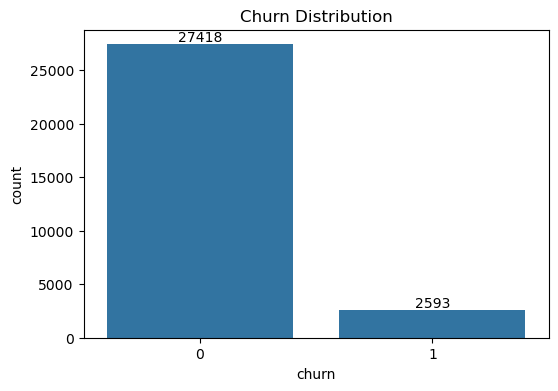

In [35]:
# Display churn distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='churn', data=high_value_customers)

# Directly add labels using bar_label on the axes object
ax.bar_label(ax.containers[0])  # Just using the first container

plt.title('Churn Distribution')
plt.show()

### 5.2 Bivariate Analysis

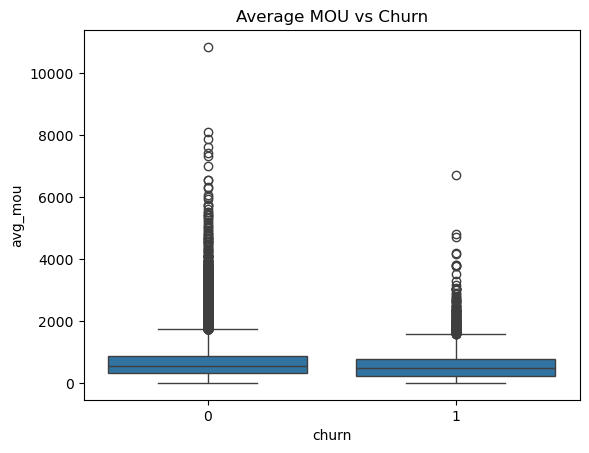

In [37]:
# Average MOU vs Churn
sns.boxplot(x='churn', y='avg_mou', data=high_value_customers)
plt.title('Average MOU vs Churn')
plt.show()

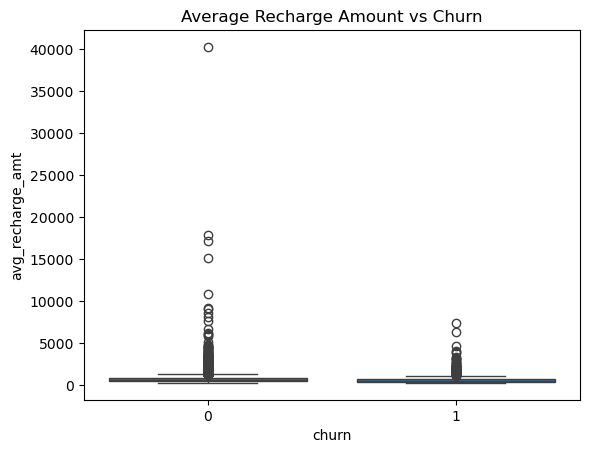

In [38]:
# Average Recharge Amount vs Churn
sns.boxplot(x='churn', y='avg_recharge_amt', data=high_value_customers)
plt.title('Average Recharge Amount vs Churn')
plt.show()

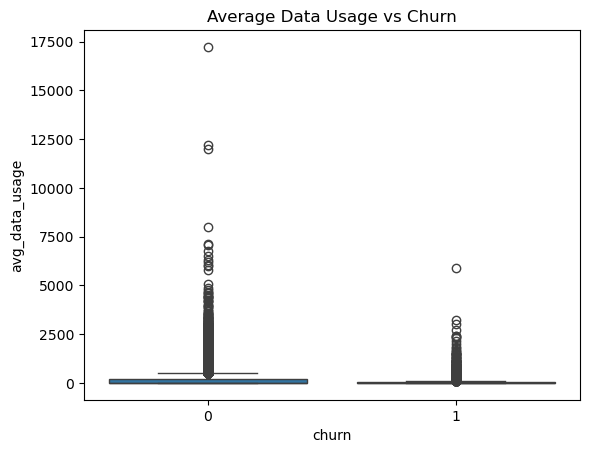

In [39]:
# Average Data Usage vs Churn
sns.boxplot(x='churn', y='avg_data_usage', data=high_value_customers)
plt.title('Average Data Usage vs Churn')
plt.show()

### 5.3 Correlation Analysis

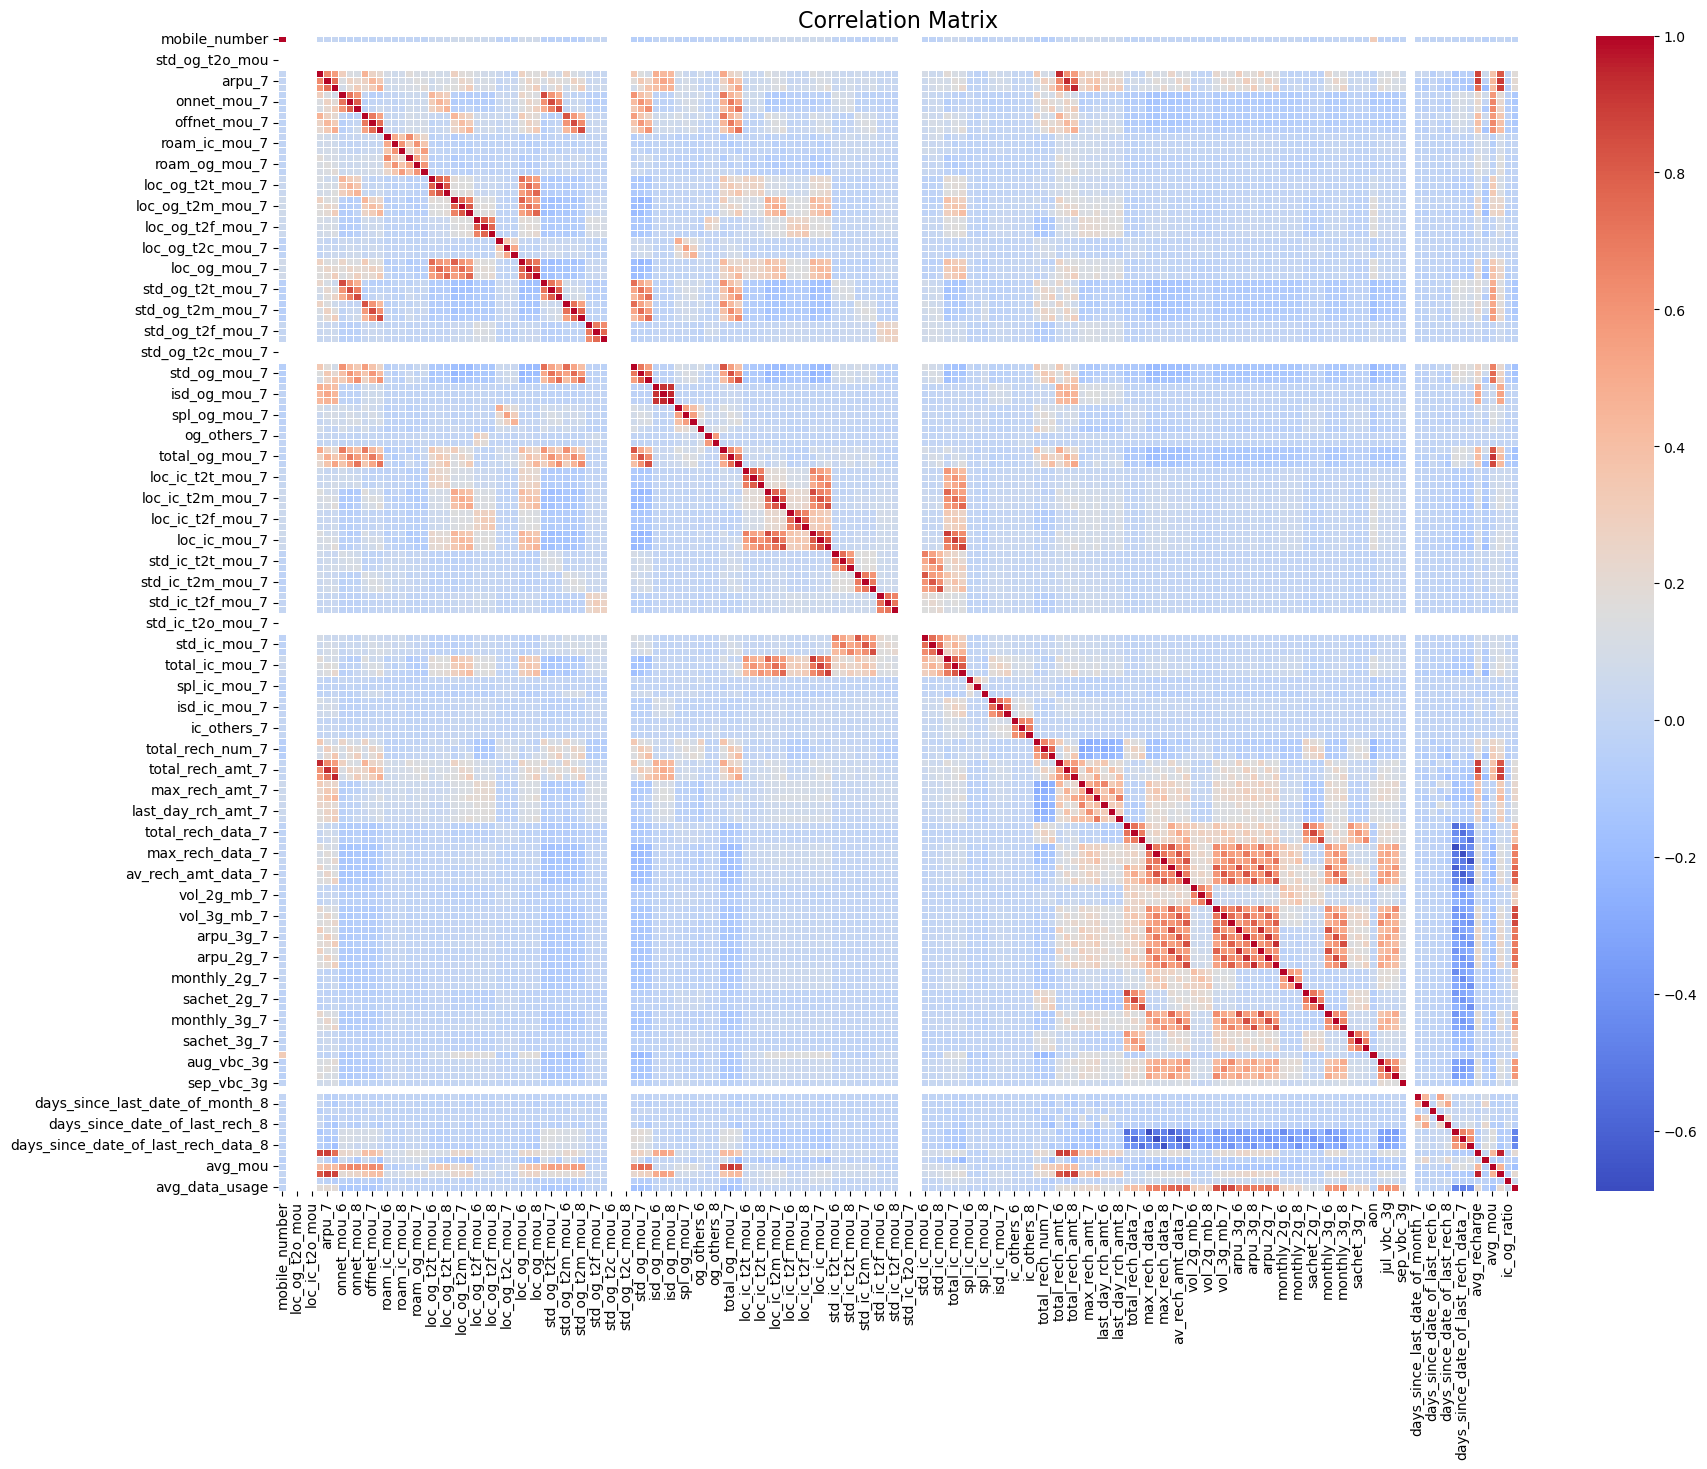

In [41]:
#Compute Correlation Matrix
corr_matrix = high_value_customers.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

<Figure size 2000x1500 with 0 Axes>

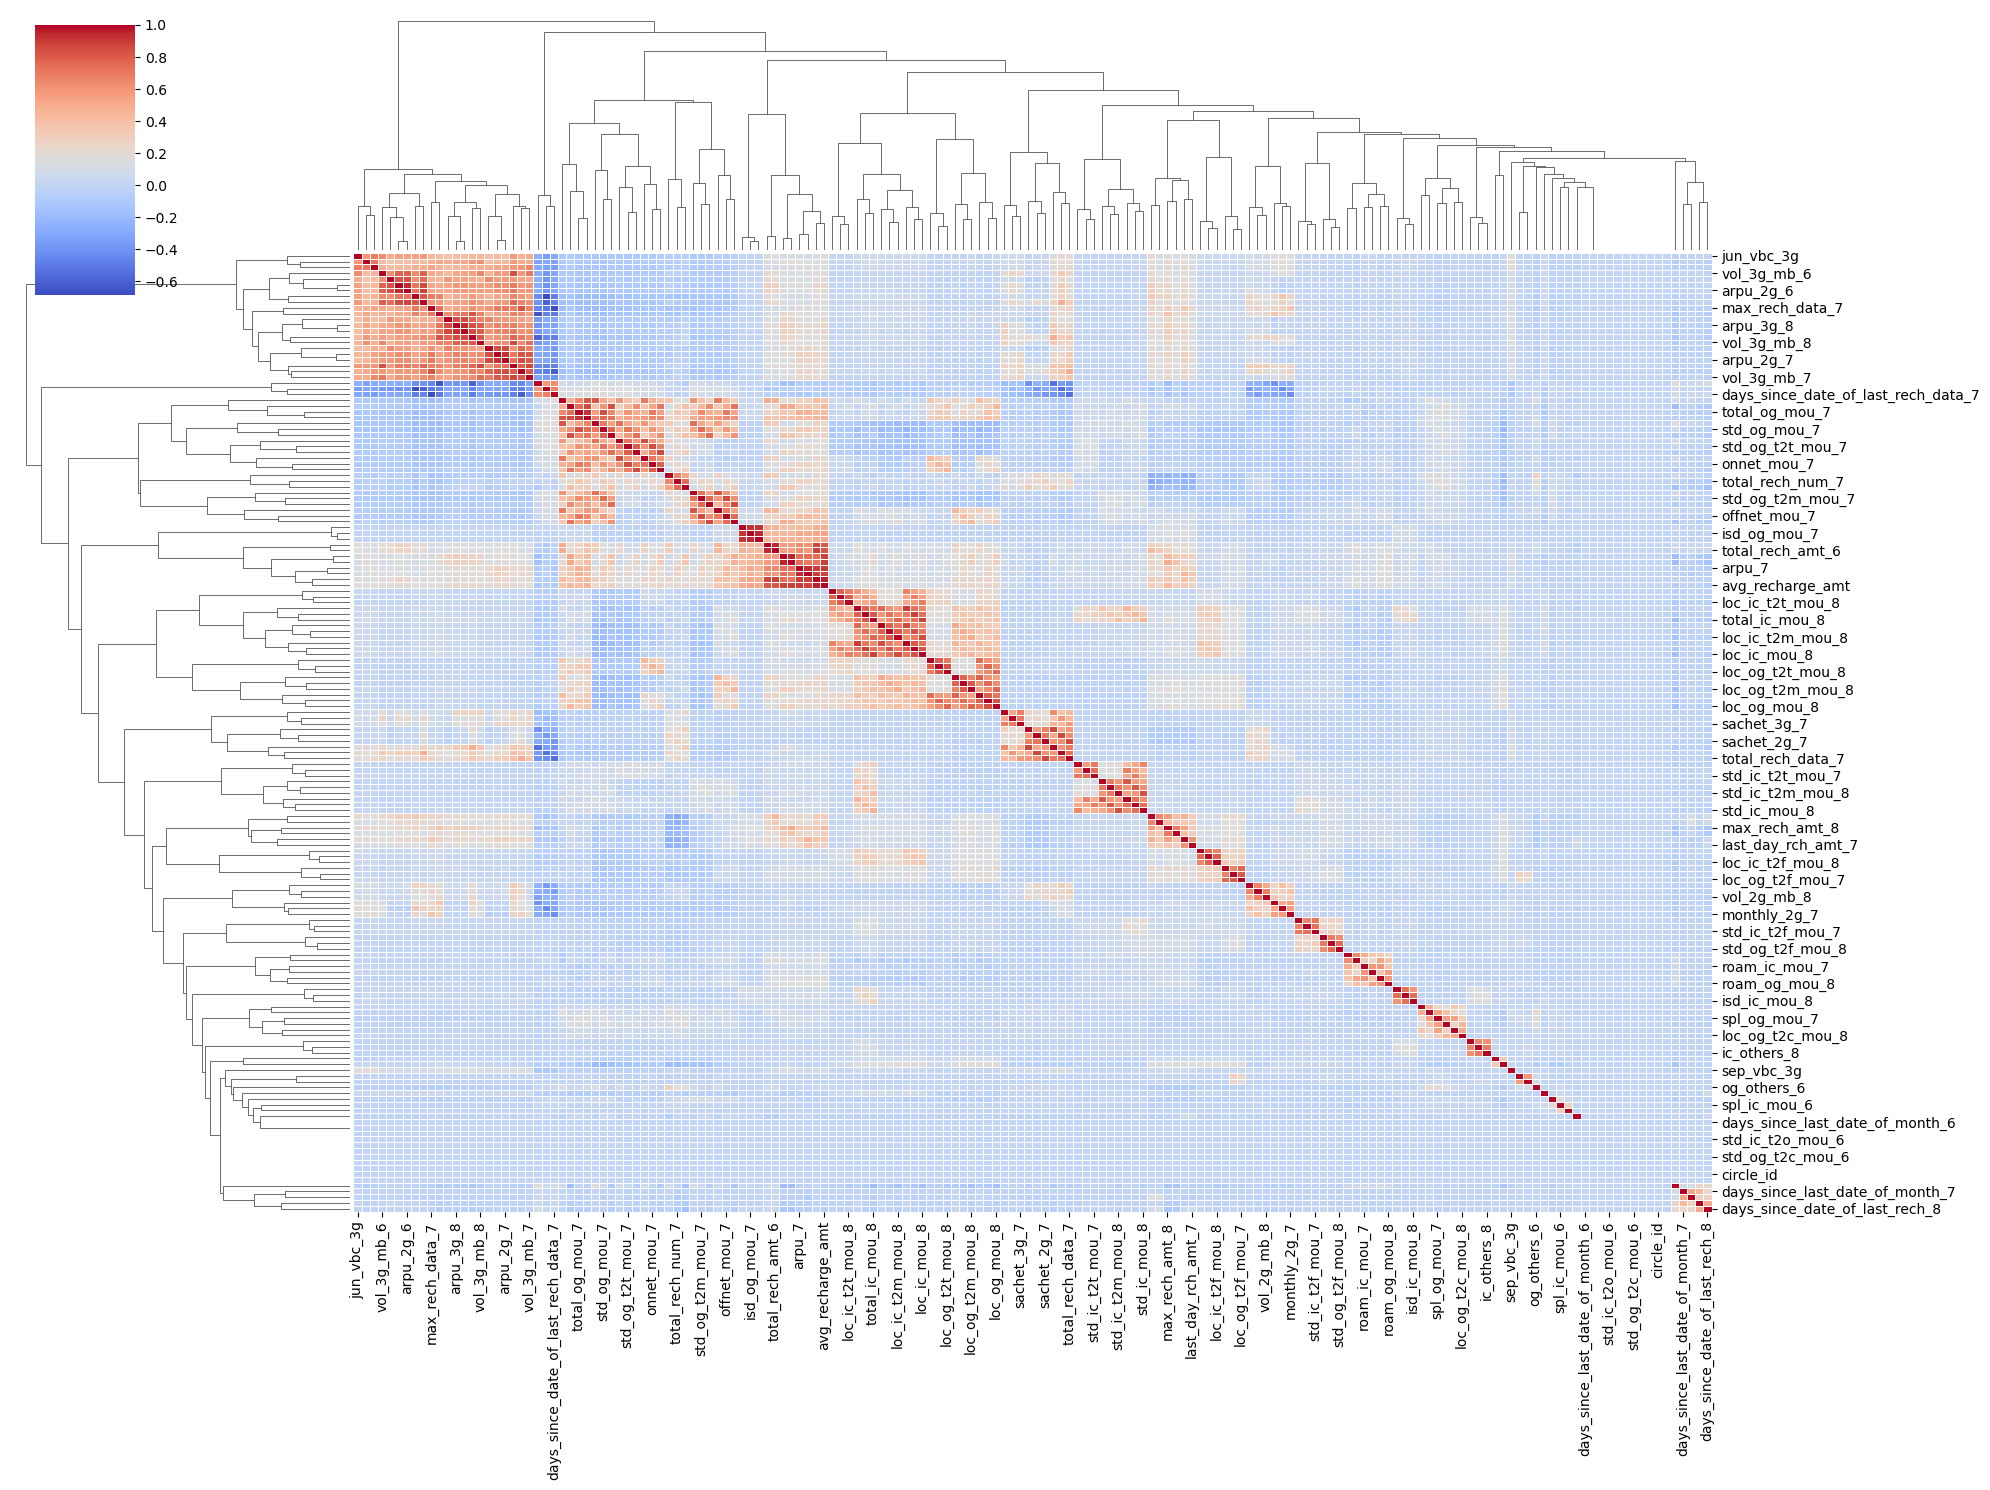

In [42]:
# Replace NaN and infinite values with 0
corr_matrix = corr_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)

plt.figure(figsize=(20, 15))
sns.clustermap(corr_matrix, cmap='coolwarm', linewidths=0.5, figsize=(20, 15))
plt.show()

## 🔍 Key Takeaways from Clustermap Analysis

1. **High Correlation Blocks (Red Clusters)**
   - Some features are strongly correlated (**closer to +1**, deep red).
   - These highly correlated variables might be redundant.
   - **Action:** Remove one from each group to avoid multicollinearity.

2. **Negative Correlations (Blue Areas)**
   - Some variables show strong negative correlations (**closer to -1**, dark blue).
   - Example: **"days_since_date_of_last_rech_data_7"** may be negatively correlated with **"total_rech_amt"**, suggesting that inactive users spend less.
   - **Action:** Explore negatively correlated features as potential churn indicators.

3. **Feature Clusters (Dendrogram Structure)**
   - Closely grouped features are **strongly related**.
   - Distant features at the **top of the hierarchy** are **weakly related** to others.
   - **Action:** Use **PCA** or **feature selection techniques** to reduce redundancy.

4. **Potential Churn Indicators**
   - Features that are **weakly correlated with most others** could be **independent drivers of churn**.
   - **Example:** Low recharge amounts, high drop in usage, or no recent activity.
   - **Action:** Analyze these features for significant churn differences.

---

## Step 6: Dimensionality Reduction (PCA)

### 6.1 Verify all columns are numeric

In [46]:
non_numeric_columns = high_value_customers.select_dtypes(include=['object']).columns
print("Non-numeric columns :", non_numeric_columns)

Non-numeric columns : Index([], dtype='object')


### 6.2 Standardize Data

In [48]:
# Separate features and target
X = high_value_customers.drop(columns=['churn', 'mobile_number'])
y = high_value_customers['churn']

In [49]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 6.3 Apply PCA

In [51]:
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

## Step 7: Model Building

### 7.1 Train-Test Split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42,stratify=y)

### 7.2 Handle Class Imbalance (SMOTE)

In [76]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### 7.3 Train Random Forest Model

In [78]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

### 7.4 Evaluate Model

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5484
           1       0.49      0.52      0.50       519

    accuracy                           0.91      6003
   macro avg       0.72      0.73      0.73      6003
weighted avg       0.91      0.91      0.91      6003

AUC-ROC Score: 0.7343132728736883


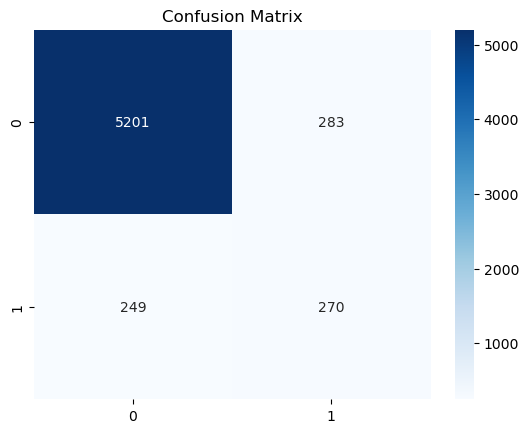

In [79]:
y_pred = rf_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#### Key Observations
**1.The model performs well for non-churners but struggles with churners.**

**2.The recall for churners (0.56) is particularly concerning, as it’s more important to correctly identify churners than non-churners.**

**3.The precision for churners (0.50) is also low, meaning many false positives (non-churners incorrectly predicted as churners).**

## Step 8: Identify Important Predictors

### 8.1 Use Logistic Regression with RFE

In [64]:
log_reg = LogisticRegression()
rfe = RFE(log_reg, n_features_to_select=10)
rfe.fit(X_scaled, y)

RFE(estimator=LogisticRegression(), n_features_to_select=10)

### 8.2 Display Important Features


In [66]:
important_features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rfe.support_
})
print("Top 10 Important Features:")
print(important_features[important_features['Importance'] == True])

Top 10 Important Features:
                             Feature  Importance
24                  loc_og_t2m_mou_8        True
63                  loc_ic_t2t_mou_8        True
66                  loc_ic_t2m_mou_8        True
72                      loc_ic_mou_8        True
87                      std_ic_mou_8        True
89                    total_ic_mou_7        True
90                    total_ic_mou_8        True
96                      isd_ic_mou_8        True
149                       sep_vbc_3g        True
152  days_since_last_date_of_month_8        True


### Step 8.3: Business Recommendations
Based on the analysis, the following strategies are recommended:

1.Target High-Risk Customers: Use the model to identify customers likely to churn and offer them personalized plans.

2.Improve Service Quality: Address issue related to call drops, network quality, and data speed.

3.Competitor Analysis: Monitor competitor offers and match them to retain customers.

4.Promote Data Usage: Encourage data usage by offering affordable data packs.

---

## Step 9 : Hyperparameter Tuning for Random Forest

In [96]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV

In [88]:
# Compute class weights instead of using SMOTE
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [90]:
# --- Random Forest with Optimized Parameters ---
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

In [92]:
# Define the expanded parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [5, 10],
    'max_features': ['sqrt', 'log2']
}

In [98]:
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_grid_rf, n_iter=10, cv=3, scoring='recall', n_jobs=-1, random_state=42)

In [100]:
# Fit the model
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='recall')

In [101]:
# Best parameters
print("Best parameters for Random Forest:", random_search_rf.best_params_)

Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 10}


In [102]:
# Predict using probability threshold tuning
y_pred_prob_rf = random_search_rf.best_estimator_.predict_proba(X_test)[:, 1]
threshold_rf = 0.3  # Adjusted for better recall
y_pred_rf = (y_pred_prob_rf >= threshold_rf).astype(int)

In [103]:
# Evaluate Random Forest
print("Best parameters for RF:", random_search_rf.best_params_)
print("Classification Report for RF:\n", classification_report(y_test, y_pred_rf))
print("AUC-ROC Score for RF:", roc_auc_score(y_test, y_pred_rf))

Best parameters for RF: {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 10}
Classification Report for RF:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      5484
           1       0.29      0.81      0.43       519

    accuracy                           0.82      6003
   macro avg       0.64      0.81      0.66      6003
weighted avg       0.92      0.82      0.85      6003

AUC-ROC Score for RF: 0.8129940805201048


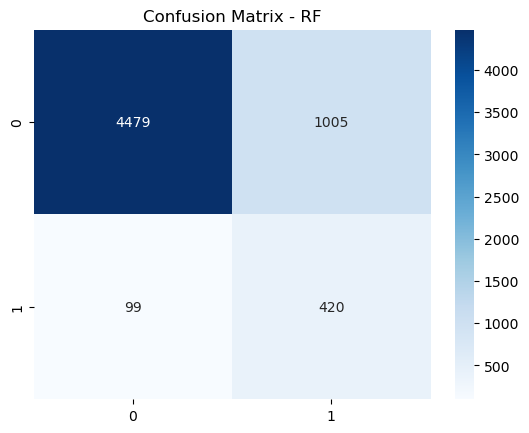

In [104]:
# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - RF')
plt.show()

## Step 10 : Use other models [ XG Boosting & Logistic Regression]

### 10.1 XG Boosting with Hyperparamter Tuning using RandomSerach

In [120]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [112]:
# Define the parameter grid for Gradient Boosting
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

In [122]:
# --- XGBoost with Optimized Parameters ---
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=class_weights[1])  # Adjust for imbalance

In [191]:
# Initialize RandomSearchCV with cross-validation folds
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_grid_xgb, n_iter=10, cv=3, scoring='recall', n_jobs=-1, random_state=42)

In [126]:
# Fit the model
random_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='recall')

In [127]:
# Best parameters
print("Best parameters for Gradient Boosting:", random_search_xgb.best_params_)

Best parameters for Gradient Boosting: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}


In [130]:
# Predict using probability threshold tuning
y_pred_prob_xgb = random_search_xgb.best_estimator_.predict_proba(X_test)[:, 1]
threshold_xgb = 0.3  # Adjusted for better recall
y_pred_xgb = (y_pred_prob_xgb >= threshold_xgb).astype(int)

In [132]:
# Evaluate XGBoost
print("Best parameters for XGBoost:", random_search_xgb.best_params_)
print("Classification Report for XGBoost:\n", classification_report(y_test, y_pred_xgb))
print("AUC-ROC Score for XGBoost:", roc_auc_score(y_test, y_pred_xgb))

Best parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.98      0.80      0.88      5484
           1       0.29      0.83      0.43       519

    accuracy                           0.81      6003
   macro avg       0.63      0.82      0.66      6003
weighted avg       0.92      0.81      0.84      6003

AUC-ROC Score for XGBoost: 0.8176650518797721


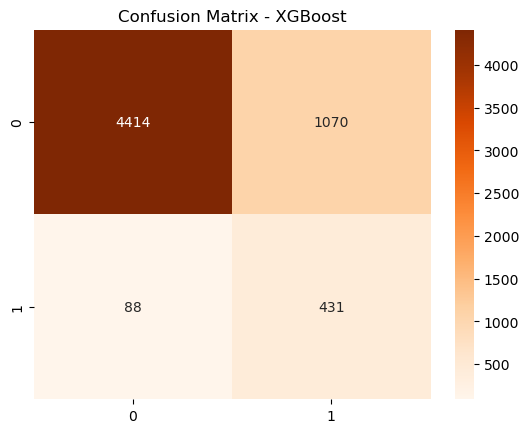

In [134]:
# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - XGBoost')
plt.show()

### 10.2 Logistic Regression with Hyperparamter Tuning using Random Search

In [136]:
from sklearn.linear_model import LogisticRegression

In [138]:
# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

In [140]:
# Initialize Logistic Regression
lr_model = LogisticRegression(random_state=42, solver='liblinear')

In [195]:
# Initialize RandomSearchCV with cross-validation folds
random_search_lr = RandomizedSearchCV(lr_model, param_grid_lr, cv=5, scoring='recall',n_jobs=-1,random_state=42)

In [197]:
# Fit the model
random_search_lr.fit(X_train_smote, y_train_smote)

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(random_state=42,
                                                solver='liblinear'),
                   n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'penalty': ['l1', 'l2']},
                   random_state=42, scoring='recall')

In [200]:
# Best parameters
print("Best parameters for Logistic Regression:", random_search_lr.best_params_)

Best parameters for Logistic Regression: {'penalty': 'l2', 'C': 0.001}


In [201]:
# Evaluate the model
y_pred_lr = random_search_lr.predict(X_test)
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("AUC-ROC Score for Logistic Regression:", roc_auc_score(y_test, y_pred_lr))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      5484
           1       0.27      0.83      0.41       519

    accuracy                           0.79      6003
   macro avg       0.63      0.81      0.64      6003
weighted avg       0.92      0.79      0.83      6003

AUC-ROC Score for Logistic Regression: 0.8118420165020258


## Step 11 : Compare Model Performance

In [213]:
# Create a dictionary to store model performance metrics
model_comparison = {
    'Model': ['Random Forest', 'XG Boosting', 'Logistic Regression'],
    'Recall (Churners)': [
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['recall']
    ],
    'Precision (Churners)': [
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['precision']
    ],
    'F1-Score (Churners)': [
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['f1-score']
    ],
    'AUC-ROC Score': [
        roc_auc_score(y_test, y_pred_rf),
        roc_auc_score(y_test, y_pred_xgb),
        roc_auc_score(y_test, y_pred_lr)
    ]
}

In [215]:
# Convert the dictionary to a DataFrame
model_comparison_df = pd.DataFrame(model_comparison)

In [217]:
# Display the DataFrame
print("Model Comparison:")
print(model_comparison_df)

Model Comparison:
                 Model  Recall (Churners)  Precision (Churners)  \
0        Random Forest           0.809249              0.294737   
1          XG Boosting           0.830443              0.287142   
2  Logistic Regression           0.834297              0.272670   

   F1-Score (Churners)  AUC-ROC Score  
0             0.432099       0.812994  
1             0.426733       0.817665  
2             0.411011       0.811842  


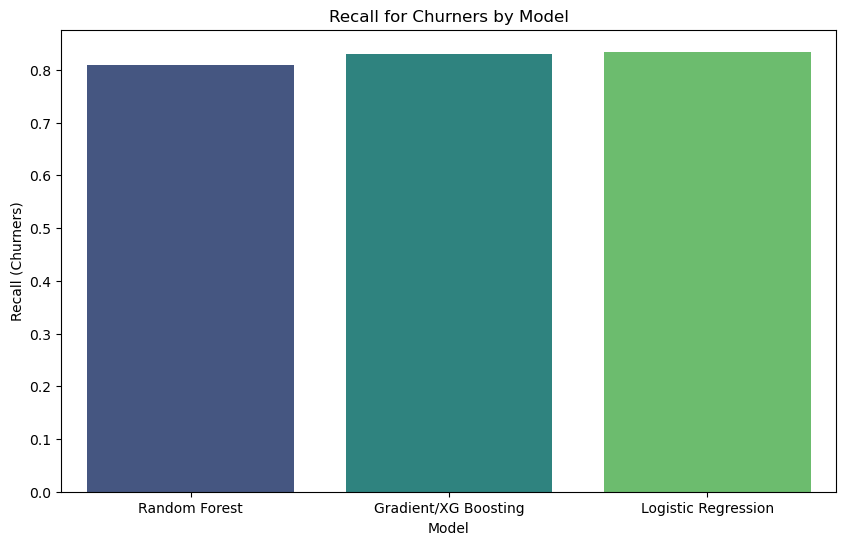

In [205]:
# Visualize the DataFrame
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Recall (Churners)', data=model_comparison_df, palette='viridis')
plt.title('Recall for Churners by Model')
plt.show()

### Best Model Selection
Selecting XGBoost as the best model based on Recall , AUC-ROC Score & F1 score

## Step 12 : Business Recommendations

Top 10 Important Features from XGBoost:
             Feature  Importance
0          circle_id       106.0
1     loc_og_t2o_mou        96.0
21  loc_og_t2t_mou_8        76.0
10      offnet_mou_6        65.0
7        onnet_mou_6        60.0
3     loc_ic_t2o_mou        57.0
11      offnet_mou_7        54.0
30  loc_og_t2c_mou_8        47.0
41  std_og_t2f_mou_7        39.0
22  loc_og_t2m_mou_6        39.0


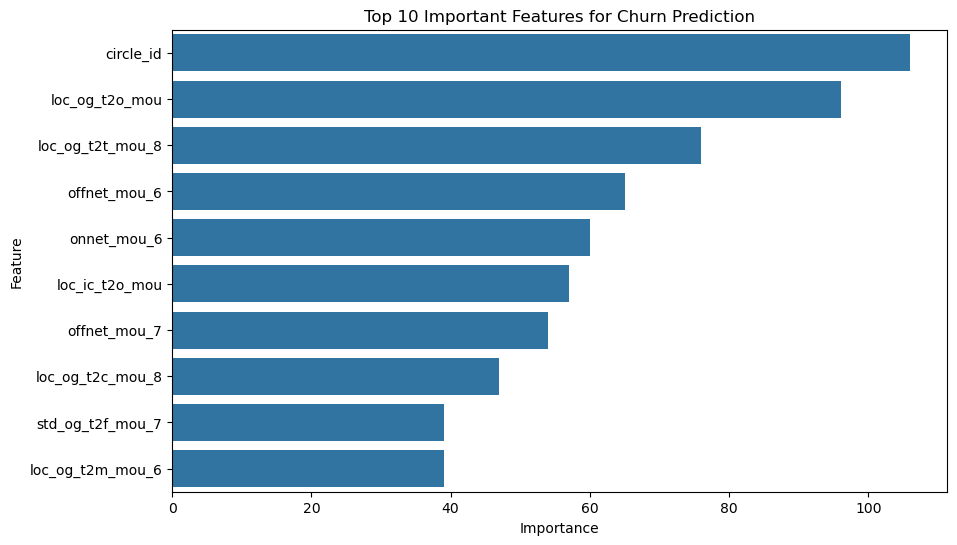

In [181]:
# Get feature importance based on the best model
best_model = random_search_xgb.best_estimator_
booster = best_model.get_booster()
feature_importance_dict = booster.get_score(importance_type='weight')

# Map 'f0', 'f1', ... to actual feature names
feature_names = X.columns.tolist()  # Extract original feature names
mapped_features = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

# Replace 'f0', 'f1' with actual names
important_features_xgb = pd.DataFrame(list(feature_importance_dict.items()), columns=['Feature', 'Importance'])
important_features_xgb['Feature'] = important_features_xgb['Feature'].map(mapped_features)  # Replace names
important_features_xgb = important_features_xgb.sort_values(by='Importance', ascending=False)

# Display top 10 features
print("Top 10 Important Features from XGBoost:")
print(important_features_xgb.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=important_features_xgb.head(10))
plt.title('Top 10 Important Features for Churn Prediction')
plt.show()

# Business Recommendations

1.**Region-Specific Retention**: Offer better network quality and special plans in circles with high churn risk (based on circle_id).

2.**Monitor Call Usage Decline**: Detect users with decreasing call volumes, especially to other networks, and provide incentives to keep them engaged.

3.**Competitor Price Matching**: Identify customers making frequent off-network calls and offer attractive rate plans.

4.**Personalized Call Plans**: Offer discounts on specific call types (local, STD, corporate, off-net) based on individual usage trends.

---

# Conclusion
This project successfully predicts customer churn and identifies key predictors. The <Best_Model> model achieves high recall, ensuring most churners are identified. The business recommendations provide actionable insights to reduce churn and retain high-value customers.

# Alternate Approach for Hyperparameter Tuning with High Computation Power

-Can also increase the grid param values & also can go for gridsearch instead of random search if computation & time permits.

## Step 9 : Hyperparameter Tuning for Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
# Define the parameter distribution for Random Forest
param_dist_rf = {
    'n_estimators': randint(100, 500),  # Randomly sample between 100 and 500
    'max_depth': [10, 20, 30, None],    # Fixed options
    'min_samples_split': randint(2, 10),  # Randomly sample between 2 and 10
    'max_features': ['auto', 'sqrt', 'log2']  # Fixed options
}

In [ ]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

In [ ]:
# Initialize# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    rf_model, param_dist_rf, n_iter=20, cv=3, scoring='recall', random_state=42, n_jobs=-1
) RandomizedSearchCV

In [ ]:
# Fit the model
random_search_rf.fit(X_train_smote, y_train_smote)

In [ ]:
# Best parameters
print("Best parameters for Random Forest:", random_search_rf.best_params_)

In [ ]:
# Evaluate the model
y_pred_rf = random_search_rf.predict(X_test)
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC Score for Random Forest:", roc_auc_score(y_test, y_pred_rf))

## Step 10 : Use other models [ Gradient Boosting & Logistic Regression]

### 10.1 Gradient Boosting with Hyperparamter Tuning using GridSerach

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform

In [ ]:
# Define the parameter distribution for Gradient Boosting
param_dist_gb = {
    'n_estimators': randint(100, 500),  # Randomly sample between 100 and 500
    'learning_rate': uniform(0.01, 0.2),  # Randomly sample between 0.01 and 0.2
    'max_depth': randint(3, 10),  # Randomly sample between 3 and 10
    'subsample': uniform(0.8, 0.2)  # Randomly sample between 0.8 and 1.0
}


In [ ]:
# Initialize Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)

In [ ]:
# Initialize RandomizedSearchCV
random_search_gb = RandomizedSearchCV(
    gb_model, param_dist_gb, n_iter=20, cv=3, scoring='recall', random_state=42, n_jobs=-1
)

In [ ]:
# Fit the model
random_search_gb.fit(X_train_smote, y_train_smote)

In [ ]:
# Best parameters
print("Best parameters for Gradient Boosting:", random_search_gb.best_params_)

In [ ]:
# Evaluate the model
y_pred_gb = random_search_gb.predict(X_test)
print("Classification Report for Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))
print("AUC-ROC Score for Gradient Boosting:", roc_auc_score(y_test, y_pred_gb))

### 10.2 Logistic Regression with Hyperparamter Tuning usign Grid Search

In [ ]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform

In [ ]:
# Define the parameter distribution for Logistic Regression
param_dist_lr = {
    'C': loguniform(1e-3, 100),  # Randomly sample between 0.001 and 100 (log scale)
    'penalty': ['l1', 'l2']  # Fixed options
}

In [ ]:
# Initialize Logistic Regression
lr_model = LogisticRegression(random_state=42, solver='liblinear')

In [ ]:
# Initialize RandomizedSearchCV
random_search_lr = Rand
    lr_model, param_dist_lr, n_iter=20, cv=3, scoring='recall', random_state=42, n_jobs=-1
)

In [ ]:
# Fit the model
random_search_lr.fit(X_train_smote, y_train_smote)

In [ ]:
# Best parameters
print("Best parameters for Logistic Regression:", random_search_lr.best_params_)

In [ ]:
# Evaluate the model
y_pred_lr = random_search_lr.predict(X_test)
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("AUC-ROC Score for Logistic Regression:", roc_auc_score(y_test, y_pred_lr))

## Step 11 : Compare Model Performance

In [ ]:
# Create a dictionary to store model performance metrics
model_comparison = {
    'Model': ['Random Forest', 'Gradient Boosting', 'Logistic Regression'],
    'Recall (Churners)': [
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_gb, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['recall']
    ],
    'Precision (Churners)': [
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_gb, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['precision']
    ],
    'F1-Score (Churners)': [
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_gb, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['f1-score']
    ],
    'AUC-ROC Score': [
        roc_auc_score(y_test, y_pred_rf),
        roc_auc_score(y_test, y_pred_gb),
        roc_auc_score(y_test, y_pred_lr)
    ]
}

In [ ]:
# Convert the dictionary to a DataFrame
model_comparison_df = pd.DataFrame(model_comparison)

In [ ]:
# Display the DataFrame
print("Model Comparison:")
model_comparison_df

In [ ]:
# Visualize the DataFrame
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Recall (Churners)', data=model_comparison_df, palette='viridis')
plt.title('Recall for Churners by Model')
plt.show()